In [1]:
import src
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

td = src.preproc.load_data()


(<Figure size 600x400 with 2 Axes>,
 array([<Axes: xlabel='time from grasp1', ylabel="('motor', 91)">,
        <Axes: xlabel='time from release1', ylabel="('motor', 91)">],
       dtype=object))

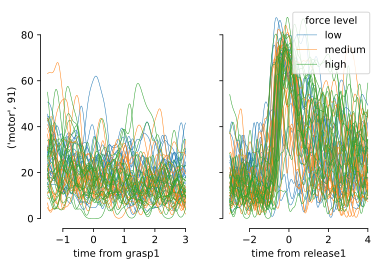

In [2]:
src.plot.plot_step_psth(td,('motor',91),single_trial=True)


/Users/raeed/codebase/0-projects/human-m1-s1-analysis/src/preproc.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('state')
/Users/raeed/codebase/0-projects/human-m1-s1-analysis/src/preproc.py:106: RuntimeWarning: Mean of empty slice
  .agg(lambda s: np.nanmean(s,axis=0))


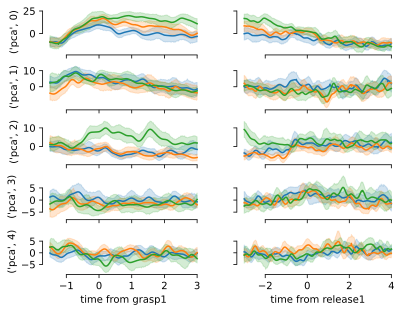

In [44]:
# z-scoring and softnorming seem to give very different results on PC space
td_shifted = src.preproc.norm_and_shift_rates(td,norm_method='softnorm')


num_comps=5
fig,axs = plt.subplots(num_comps,2,sharex='col',sharey='row')
for compnum in range(num_comps):
    src.plot.plot_pcs(
        td_shifted,
        'sensory',
        compnum,
        axs=axs[compnum,:],
        add_legend=False,
        single_trial=False,
    )


/Users/raeed/codebase/0-projects/human-m1-s1-analysis/src/preproc.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('state')
/Users/raeed/codebase/0-projects/human-m1-s1-analysis/src/preproc.py:106: RuntimeWarning: Mean of empty slice
  .agg(lambda s: np.nanmean(s,axis=0))


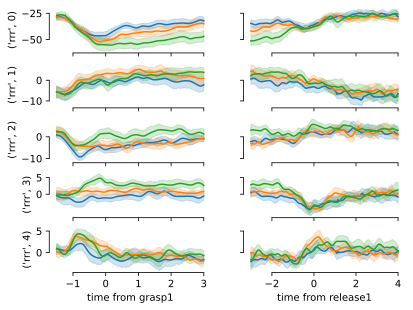

In [45]:
# z-scoring and softnorming seem to give very different results on PC space
td_shifted = src.preproc.norm_and_shift_rates(td,norm_method='softnorm')

num_comps=5
fig,axs = plt.subplots(num_comps,2,sharex='col',sharey='row')
for compnum in range(num_comps):
    src.plot.plot_rrr_comps(
        td_shifted,
        compnum,
        axs=axs[compnum,:],
        add_legend=False,
        single_trial=False,
    )


In [ ]:
step_ramp_data = (
    pd.concat([
        td_shifted.groupby('trial type').get_group(g)
        for g in ['step']
    ])
)
event_times = src.events.get_state_transition_times(step_ramp_data['state'])
grasp_times = event_times.loc[(slice(None),slice(None),'grasp1')]
release_times = event_times.loc[(slice(None),slice(None),'release1')]
hold_lens = release_times-grasp_times
sns.histplot(hold_lens.dt.total_seconds())